In [1]:
import numpy as np
import scipy.sparse as sp
import torch
from torch import nn
from torch.optim import Adam, Optimizer
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_sparse import SparseTensor
from tqdm import trange

from src.recommender_model import RecommenderModel
from src.utils import plot_losses, evaluate_model, train_model, write_submission

In [2]:
class URMDataLoaderWithNegativeSampling:
	"""Custom URM Dataset with Negative Sampling."""
	def __init__(self, urm: sp.csr_matrix, batch_size: int):
		self.urm = urm
		self.num_items = self.urm.shape[1]
		self.batch_size = batch_size

		urm_coo = self.urm.tocoo()
		self.user_item_coordinates = np.vstack((urm_coo.row, urm_coo.col)).T
		self.user_item_sets = {
			user_id: set(self.urm.getrow(user_id).indices)
			for user_id in range(self.urm.shape[0])
		}

		self.curr_batch_idx = 0
		self.length = int(np.ceil(len(self.user_item_coordinates) / self.batch_size))

		self.shuffle()

	def __len__(self):
		"""Number of batches."""
		return self.length

	def __next__(self):
		"""Fetches a whole batch."""
		if self.curr_batch_idx >= self.length:
			raise StopIteration

		start_idx = self.curr_batch_idx * self.batch_size
		end_idx = min(start_idx + self.batch_size, len(self.user_item_coordinates))

		batch_data = self.user_item_coordinates[start_idx:end_idx]
		users = batch_data[:, 0]
		pos_samples = batch_data[:, 1]

		neg_samples = np.zeros((end_idx - start_idx,), dtype=np.int64)
		for sample_idx, user in enumerate(users):
			while True:
				neg_sample = np.random.randint(self.num_items)
				if neg_sample not in self.user_item_sets[user]:
					neg_samples[sample_idx] = neg_sample
					break

		self.curr_batch_idx += 1
		return users, pos_samples, neg_samples

	def __iter__(self):
		self.curr_batch_idx = 0
		return self

	def shuffle(self):
		"""Shuffle the dataset."""
		np.random.shuffle(self.user_item_coordinates)

In [3]:
def bpr_loss(pos_scores, neg_scores):
	return -torch.mean(torch.log(torch.sigmoid(pos_scores - neg_scores)))

In [4]:
class LightGCNModel(nn.Module):
	def __init__(self, num_users: int, num_items: int, num_layers: int = 3, embedding_dim: int = 64):
		super(LightGCNModel, self).__init__()

		self.num_users = num_users
		self.num_items = num_items

		self.users_embeddings = nn.Embedding(num_embeddings=self.num_users, embedding_dim=embedding_dim)
		self.items_embeddings = nn.Embedding(num_embeddings=self.num_items, embedding_dim=embedding_dim)

		nn.init.xavier_uniform_(self.users_embeddings.weight)
		nn.init.xavier_uniform_(self.items_embeddings.weight)

		self.aggregation_layer = nn.Parameter(torch.ones(num_layers + 1) / (num_layers + 1))  # aggregation of layers outputs

		self.num_layers = num_layers

	def forward(self, edge_index: SparseTensor) -> tuple[torch.tensor, torch.tensor]:
		x = torch.cat([self.users_embeddings.weight, self.items_embeddings.weight])

		layers_output = [x]
		for _ in range(self.num_layers):
			x = edge_index @ x
			layers_output.append(x)

		final_embeddings = (torch.stack(layers_output, dim=1) * self.aggregation_layer.view(-1, 1)).sum(dim=1)

		return final_embeddings[:self.num_users], final_embeddings[self.num_users:]

In [5]:
class LightGCN(RecommenderModel):
	def __init__(self):
		super(LightGCN, self).__init__()
		self.model: nn.Module | None = None
		self.optimizer: Optimizer | None = None
		self.loss_fn = None
		self.edge_index: SparseTensor | None = None
		self.edge_index_norm: SparseTensor | None = None
		self.best_map = 0.0

	def fit(self, urm: sp.csr_matrix, icm: sp.csr_matrix, urm_val: sp.csr_matrix, lr: float = .001, embedding_dim: int = 32, num_layers: int = 3, epochs: int = 10, batch_size: int = 2**14, weight_decay: float = 1e-8, plot_loss: bool = True)-> None:
		self.urm = urm
		num_users, num_items = self.urm.shape
		num_nodes = num_users + num_items
		self.model = LightGCNModel(num_users, num_items, num_layers=num_layers, embedding_dim=embedding_dim)
		self.optimizer = Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
		self.loss_fn = bpr_loss

		validation_enabled = urm_val.nnz > 0

		print("Building the datasets...")

		urm_coo = self.urm.tocoo()
		users_nodes, items_nodes = torch.from_numpy(urm_coo.row).long(), torch.from_numpy(urm_coo.col + num_users).long()
		self.edge_index = SparseTensor(
			row=torch.cat((users_nodes, items_nodes), dim=0),
			col=torch.cat((items_nodes, users_nodes), dim=0),
			sparse_sizes=(num_nodes, num_nodes),
		)  # we concatenate the tensors to make the graph undirected

		self.edge_index_norm = gcn_norm(self.edge_index, add_self_loops=False)

		dataloader = URMDataLoaderWithNegativeSampling(urm, batch_size=batch_size)
		dataloader_val = URMDataLoaderWithNegativeSampling(urm_val, batch_size=batch_size)
		dl_len = len(dataloader)

		loss_history_val = np.zeros(epochs + 1)
		map_history = np.zeros(epochs + 1)
		loss_history = np.zeros((dl_len * epochs,))

		if validation_enabled:
			self._compute_full_urm_pred()
			map_history[0], loss_history_val[0] = self._validate(dataloader_val, urm_val)

		print("Training the model...")
		for epoch in (t := trange(epochs)):
			self.model.train()
			for batch_idx, (users, pos_samples, neg_samples) in enumerate(dataloader):
				users_embeddings, items_embeddings = self.model(self.edge_index_norm)

				batch_users_embeddings = users_embeddings[users]
				pos_items_embeddings = items_embeddings[pos_samples]
				neg_items_embeddings = items_embeddings[neg_samples]

				pos_scores = (batch_users_embeddings * pos_items_embeddings).sum(dim=1)
				neg_scores = (batch_users_embeddings * neg_items_embeddings).sum(dim=1)

				loss = self.loss_fn(pos_scores, neg_scores)

				self.optimizer.zero_grad()
				loss.backward()
				self.optimizer.step()

				loss_history[dl_len * epoch + batch_idx] = loss.item()
				with torch.no_grad():
					t.set_postfix({
						"Batch": f"{(batch_idx + 1) / dl_len * 100:.2f}%",
						"Train loss": f"{loss.item():.5f}",
						"Val loss": f"{loss_history_val[epoch]:.5f}",
						"MAP@10": f"{map_history[epoch]:.5f}",
						"Best MAP@10": f"{self.best_map:.5f}",
					})
			if validation_enabled:
				self._compute_full_urm_pred()
				map_history[epoch + 1], loss_history_val[epoch + 1] = self._validate(dataloader_val, urm_val)
				self.best_map = max(self.best_map, map_history[epoch + 1])

		if not validation_enabled:
			self._compute_full_urm_pred()  # as it has not been done before

		plot_losses(epochs, loss_history, loss_history_val, len(dataloader), ('MAP@10', [x * len(dataloader) for x in range(epochs + 1)], map_history))
	@torch.no_grad()
	def _compute_full_urm_pred(self) -> None:
		"""In-place computation of the final predicted URM matrix using the final Linear layer"""
		self.model.eval()
		del self.urm_pred  # free memory

		users_embeddings, items_embeddings = self.model(self.edge_index_norm)
		self.urm_pred = (
			users_embeddings @ items_embeddings.T
		).numpy()

	@torch.no_grad()
	def _validate(self, dataloader_val: URMDataLoaderWithNegativeSampling, urm_val: sp.csr_matrix) -> tuple[float, float]:
		self.model.eval()
		loss = 0
		users_embeddings, items_embeddings = self.model(self.edge_index_norm)
		for batch_idx, (users, pos_samples, neg_samples) in enumerate(dataloader_val):
			batch_users_embeddings = users_embeddings[users]
			pos_items_embeddings = items_embeddings[pos_samples]
			neg_items_embeddings = items_embeddings[neg_samples]

			pos_scores = (batch_users_embeddings * pos_items_embeddings).sum(dim=1)
			neg_scores = (batch_users_embeddings * neg_items_embeddings).sum(dim=1)

			loss += self.loss_fn(pos_scores, neg_scores)

		loss /= len(dataloader_val)
		return evaluate_model(self, urm_val, users_to_test=.2), loss.item()

Building the datasets...
Training the model...


100%|██████████| 20/20 [17:22<00:00, 52.14s/it, Batch=100.00%, Train loss=0.07062, Val loss=0.15356, MAP@10=0.01526, Best MAP@10=0.01542]


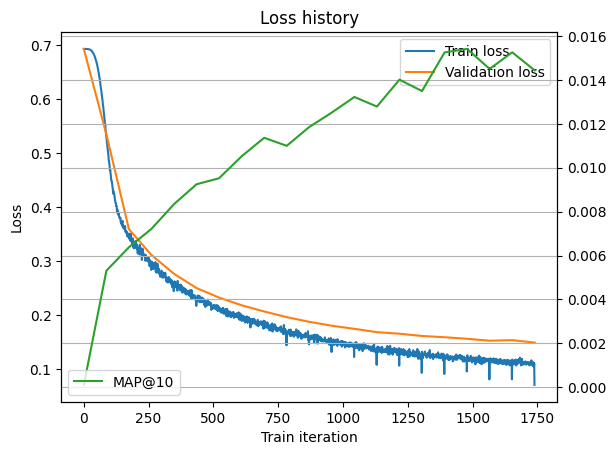

MAP@10 evaluation of the LightGCN model: 0.01571


In [6]:
lightgcn_train = train_model(LightGCN(), epochs=20)

In [7]:
lightgcn_submission = train_model(LightGCN(), test_size=0, epochs=20, embedding_dim=32)
write_submission(lightgcn_submission, "lightgcn_submission.csv")

Building the datasets...
Training the model...


  0%|          | 0/20 [00:10<?, ?it/s, Batch=10.19%, Train loss=0.69311, Val loss=0.00000, MAP@10=0.00000, Best MAP@10=0.00000]


KeyboardInterrupt: 

Submission result: `0.0xxxx`